In [1]:
import torch 
import pandas as pd 
import numpy as np
import os
from lincs_gsnn.data.DXDTDataset import DXDTDataset
from torch.utils.data import DataLoader 

from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from lincs_gsnn.models.ODEFunc import ODEFunc
from lincs_gsnn.data.TrajDataset import TrajDataset
from torchdiffeq import odeint 

import networkx as nx

%load_ext autoreload
%autoreload 2


In [2]:
data = torch.load('/home/teddy/local/lincs-gsnn/workflow/runs/default/bionetwork/bionetwork.pt', weights_only=False)
model = torch.load('../workflow/runs/default/pretrain/pretrained_model.pt', weights_only=False)
dxdt_scale = torch.load('../workflow/runs/default/pretrain/dxdt_scale.pt', weights_only=False).item()
x_names = pd.read_csv('/home/teddy/local/lincs-traj/workflow/runs/exp/default_v02/output/predict_grid/gene_names.csv')['gene_names'].values.astype(str)
meta = pd.read_csv('/home/teddy/local/lincs-traj/workflow/runs/exp/default_v02/output/predict_grid/pred_meta.csv')


/home/teddy/miniconda3/envs/gsnn-lib/lib/python3.12/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/teddy/miniconda3/envs/gsnn-lib/lib/python3.12/site-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [3]:
x_names[0]

'GNPDA1'

In [3]:
# Given a condition (set of dxdt obs within a condition), what edges are necessary to maintain the predicted values?

drug = 'BRD-K49328571'
cell = 'HME1'

cond = meta[(meta['pert_id'] == drug) & (meta['cell_iname'] == cell)]
cond.shape

(6, 7)

In [4]:
horizon = 50

dataset = TrajDataset(cond, 
                      input_names=data.node_names_dict['input'], 
                      obs_dir='/home/teddy/local/lincs-traj/workflow/runs/exp/default_v02/output/predict_grid/obs',
                      horizon=horizon, 
                      multiple_shooting=True)

dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [5]:
# freeze the model 
for param in model.parameters():
    param.requires_grad = False
model = model.eval() 

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
func = ODEFunc(model, scale=dxdt_scale, input_names=data.node_names_dict['input']).to(device)

edge_weight = torch.nn.Parameter(3*torch.ones(model.edge_index.shape[1], device=device), requires_grad=True)
optim = torch.optim.Adam([edge_weight], lr=1e-1) 
crit = torch.nn.MSELoss() 
beta = 1e-3

# which gene dynamics do we want to explain? 
target_ixs = [0] # torch.arange(len(x_names)) 


In [7]:
beta = 1e-4

In [8]:
min_time = meta.time_min.values[0]
max_time = meta.time_max.values[0] 
n_time = meta.n_time_pts.values[0]
dt = (max_time - min_time) / (n_time - 1) 

#t = torch.linspace(min_time, max_time, n_time, device=device)
t = torch.linspace(0, horizon*dt, horizon, device=device)

In [9]:

mses = [] 
norms = [] 
for epoch in range(500):
    for i, (xt, _, X) in enumerate(dataloader):
        optim.zero_grad()

        X = X.to(device)
        xt = xt.to(device)

        func.set_edge_mask(edge_weight.sigmoid())

        out = odeint(func=func, y0=X, t=t, method='dopri5').transpose(0, 1)  # (n_time, B, n_input_nodes) 
        xt_hat = out[:, :, func.gene_ixs]  # (n_time, B, n_genes)

        mse = crit(xt_hat[:, :, target_ixs], xt[:, :, target_ixs]) 
        loss = mse + beta*edge_weight.sigmoid().norm()
        loss.backward()
        optim.step()

        r2 = r2_score(xt.cpu().numpy()[:, :, target_ixs].ravel(), xt_hat.detach().cpu().numpy()[:, :, target_ixs].ravel())

    print(f'Epoch {epoch}, mse: {mse:.3f}, Loss: {loss:.3f}, r2: {r2:.3f}, Edge Weight Norm: {edge_weight.sigmoid().norm().item():.3f}', end='\r')
    mses.append(mse.item())
    norms.append(edge_weight.sigmoid().norm().item())


R2 score: 0.57


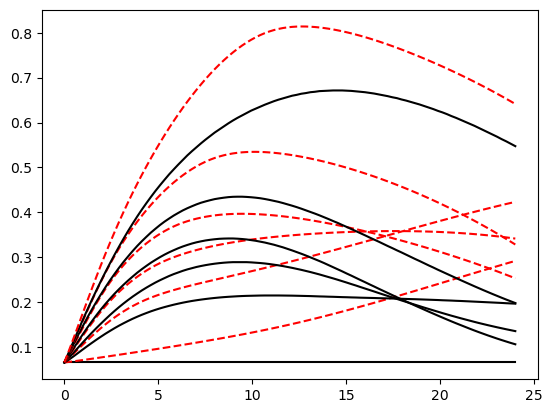

In [10]:
full_dataset = TrajDataset(cond, 
                      input_names=data.node_names_dict['input'], 
                      obs_dir='/home/teddy/local/lincs-traj/workflow/runs/exp/default_v02/output/predict_grid/obs')

full_dataloader = DataLoader(full_dataset, batch_size=8, shuffle=False)

# discretize edge weight 
func.set_edge_mask(1.*(edge_weight.sigmoid() > 0.5))
#func.set_edge_mask(edge_weight.sigmoid())
#func.set_edge_mask(None)

xt_mu, xt_sigma, X = next(iter(full_dataloader))

xt_mu = xt_mu.to(device)
xt_sigma = xt_sigma.to(device)
X = X.to(device)

t = torch.linspace(min_time, max_time, n_time, device=device)

with torch.no_grad():
    out = odeint(func=func, y0=X, t=t, method='dopri5').transpose(0, 1)  # (B, n_time, n_input_nodes) 

xt_hat = out[:, :, func.gene_ixs]  # (n_time, B, n_genes)

delta_ = xt_mu.detach().cpu().numpy() - xt_mu[:, [0], :].detach().cpu().numpy()
delta_hat_ = xt_hat.detach().cpu().numpy() - xt_mu[:, [0], :].detach().cpu().numpy()

delta_ = delta_[:, :, target_ixs]
delta_hat_ = delta_hat_[:, :, target_ixs]

r2 = r2_score(delta_.ravel(), delta_hat_.ravel(), multioutput='uniform_average')
print(f'R2 score: {r2:.2f}')

## plot 

gene_ix = target_ixs

plt.figure() 
for i in range(xt_mu.shape[0]):
    plt.plot(t.cpu().numpy(), xt_mu.detach().cpu().numpy()[i, :, gene_ix].ravel(), 'k')
    plt.plot(t.cpu().numpy(), xt_hat.detach().cpu().numpy()[i, :, gene_ix].ravel(), 'r--')

plt.show() 

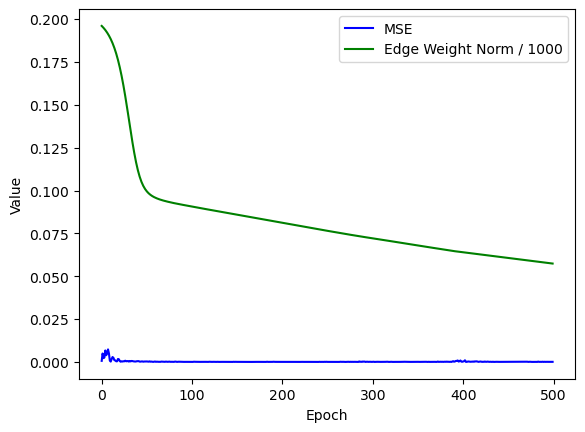

In [11]:
plt.figure() 
plt.plot(mses, 'b-', label='MSE')
plt.plot(np.array(norms)/1000, 'g-', label='Edge Weight Norm / 1000')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

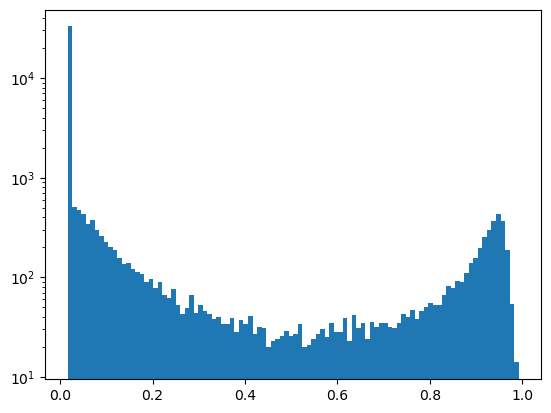

In [12]:
plt.figure() 
plt.hist(edge_weight.sigmoid().detach().cpu().numpy(), bins=100)
plt.yscale('log')
plt.show() 

In [13]:
edge_mask = (edge_weight.sigmoid().detach().cpu().numpy() > 0.9)
sum(edge_mask)

2236

In [14]:
data.edge_index_dict['function', 'to', 'function'].shape

torch.Size([2, 22982])

In [15]:
edge_weight.sigmoid().detach().cpu().numpy()[model.function_edge_mask.cpu()].shape

(24422,)

In [16]:
np.array(model.homo_names)[model.edge_index[:, model.function_edge_mask][0].cpu()]

array(['PROTEIN__P01106', 'PROTEIN__P05412', 'PROTEIN__P84022', ...,
       'RNA__Q9Y6P5', 'RNA__Q9Y6Q9', 'RNA__Q9Y6R4'], dtype='<U19')

In [17]:

res = pd.DataFrame({'src': np.array(model.homo_names)[model.edge_index[:, model.function_edge_mask][0].cpu()],
                     'dst': np.array(model.homo_names)[model.edge_index[:, model.function_edge_mask][1].cpu()],
                     'weight': edge_weight.sigmoid().detach().cpu().numpy()[model.function_edge_mask.cpu()]})

res = res.assign(src_uniprot = [x.split('__')[1] for x in res.src])
res = res.assign(dst_uniprot = [x.split('__')[1] for x in res.dst])

res = res.assign(src_type = [x.split('__')[0] for x in res.src])
res = res.assign(dst_type = [x.split('__')[0] for x in res.dst])

res.sort_values('weight', ascending=False)

,src,dst,weight,src_uniprot,dst_uniprot,src_type,dst_type
23153,PROTEIN__P36507,PROTEIN__P36507,0.990878,P36507,P36507,PROTEIN,PROTEIN
19136,PROTEIN__P29323,PROTEIN__P01100,0.989694,P29323,P01100,PROTEIN,PROTEIN
21816,PROTEIN__P45983,PROTEIN__P14921,0.988919,P45983,P14921,PROTEIN,PROTEIN
18504,PROTEIN__P03372,PROTEIN__P23771,0.987805,P03372,P23771,PROTEIN,PROTEIN
22916,RNA__Q9BWU1,PROTEIN__Q9BWU1,0.986899,Q9BWU1,Q9BWU1,RNA,PROTEIN
...,...,...,...,...,...,...,...
6817,PROTEIN__P14921,RNA__Q02224,0.017105,P14921,Q02224,PROTEIN,RNA
23791,RNA__P35250,RNA__P35250,0.017105,P35250,P35250,RNA,RNA
7942,PROTEIN__P01100,RNA__Q15050,0.017105,P01100,Q15050,PROTEIN,RNA
22165,PROTEIN__P41235,RNA__MIMAT0000095,0.017097,P41235,MIMAT0000095,PROTEIN,RNA


In [18]:
G = nx.DiGraph()

for i,row in res[lambda x: x. weight > 0.5].iterrows(): 
    G.add_edge(row.src, row.dst)

len(G)

487

In [19]:
inp_names   = data['node_names_dict']['input']
func_names  = data['node_names_dict']['function']
edge_mat    = data['edge_index_dict'][('input','to','function')]

try:
    drug_idx = inp_names.index(f"DRUG__{drug}")
except ValueError:
    raise KeyError(f"{drug} not found among {len(inp_names)} input nodes")

src, dst         = edge_mat
mask             = (src == drug_idx)
drug_targets_idx = dst[mask].cpu().tolist()
drug_targets     = [func_names[i] for i in drug_targets_idx]

In [20]:
# add drug node
drug_idx = data.node_names_dict['input'].index('DRUG__' + drug)
row,col = data.edge_index_dict['input','to','function'] 
drug_edge_mask = row == drug_idx 
drug_edges = data.edge_index_dict['input','to','function'][:, drug_edge_mask]
drug_targets = np.array(data.node_names_dict['function'])[drug_edges[1]]

ii = 0
for i in range(drug_edges.shape[1]): 
    src,dst = drug_edges[:, i] 
    src_name = data.node_names_dict['input'][src]
    dst_name = data.node_names_dict['function'][dst]

    if dst_name in G: 
        ii+=1
        G.add_edge(src_name, dst_name)

ii

62

In [21]:
#pos = nx.spring_layout(G, k=1) 
H = nx.convert_node_labels_to_integers(G, label_attribute="node_label")
H_layout = nx.nx_pydot.pydot_layout(H, prog="dot")
pos = {H.nodes[n]["node_label"]: p for n, p in H_layout.items()}

KeyboardInterrupt: 

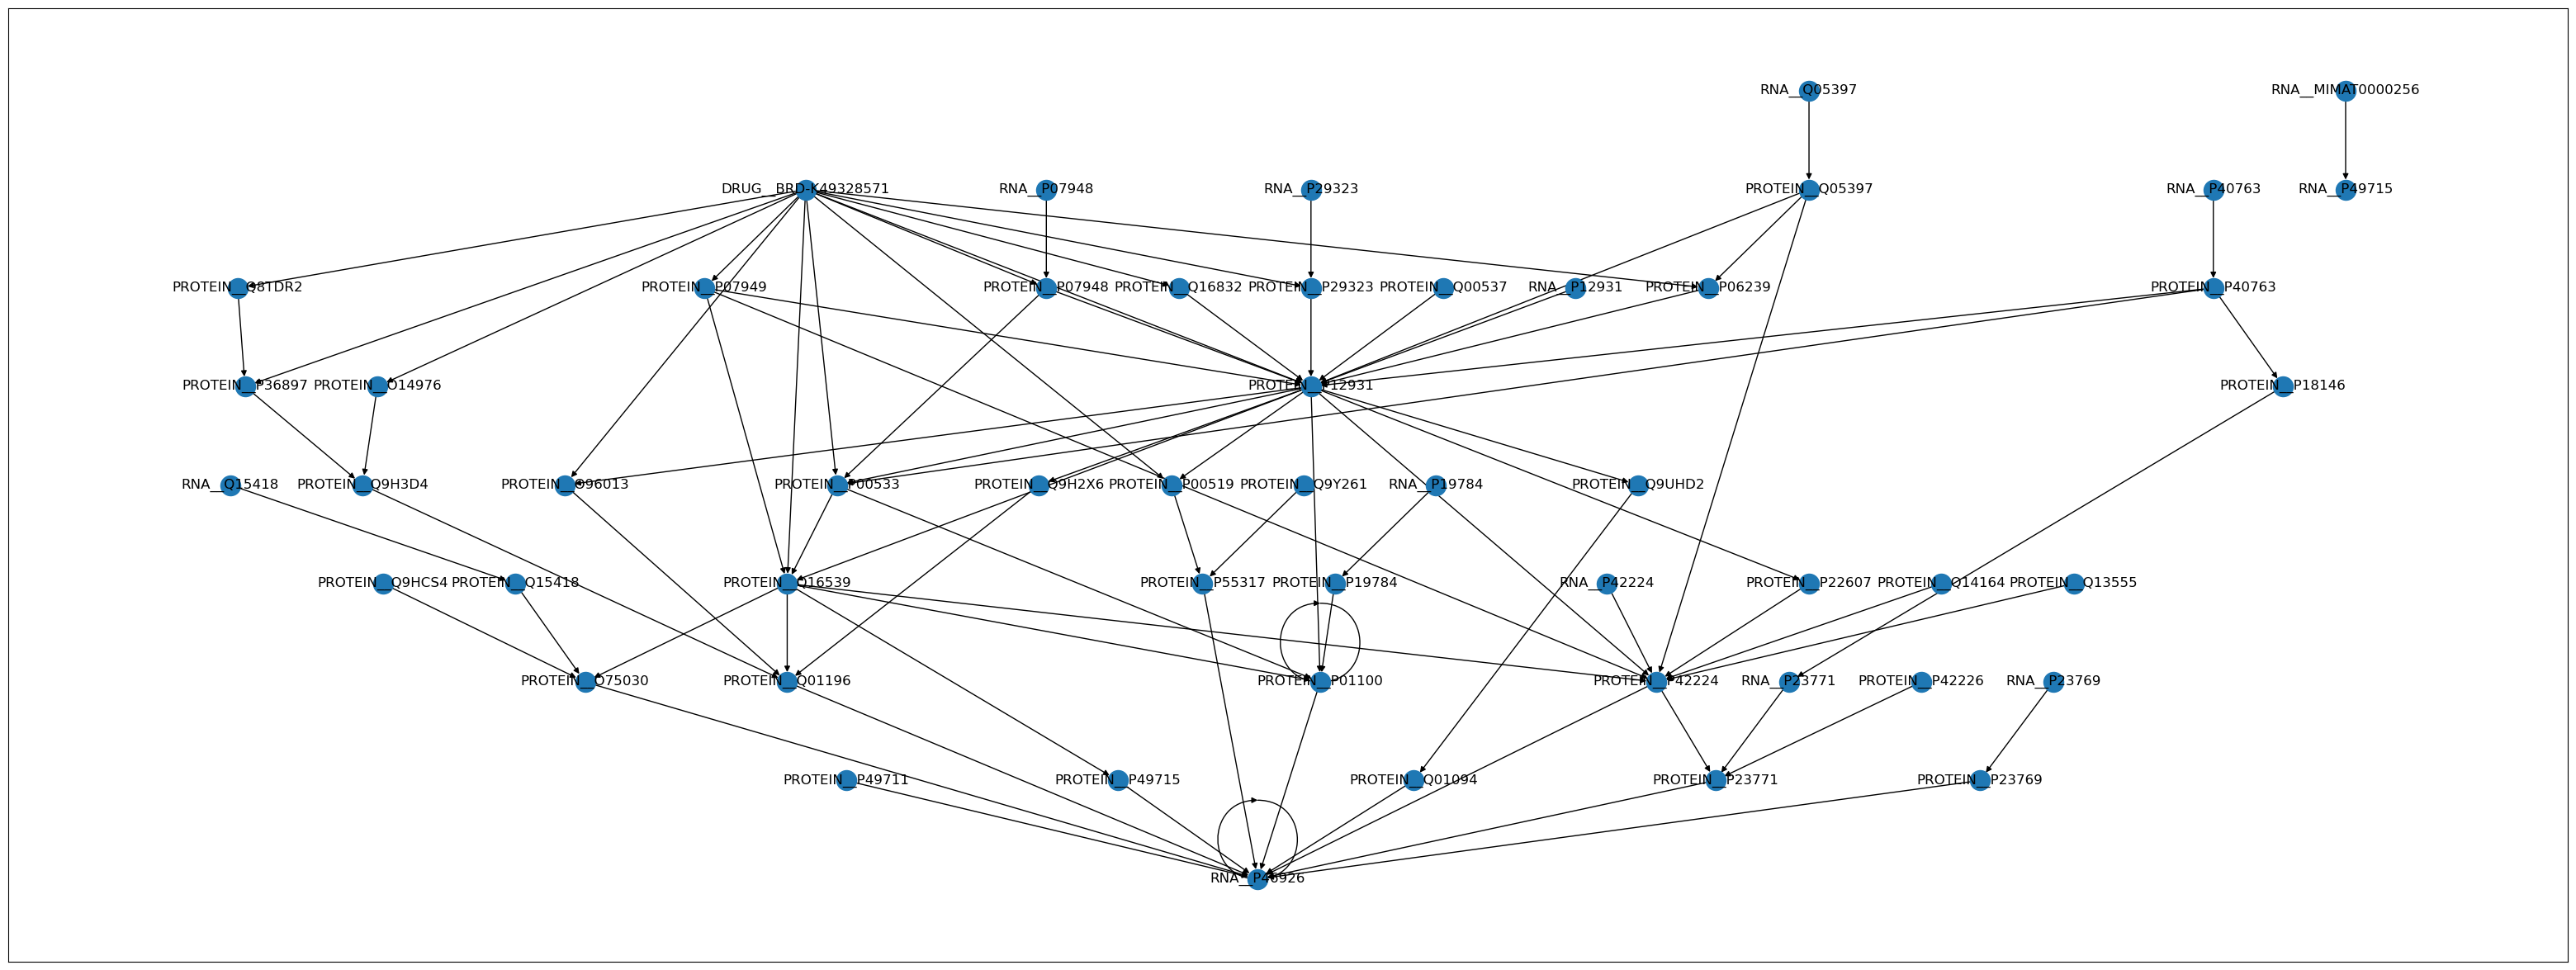

In [ ]:
plt.figure(figsize=(40,15)) 
nx.draw_networkx(G, pos=pos)
plt.show() 

In [ ]:
x_names[0]

'GNPDA1'

In [ ]:
pd.read_csv('../extdata/landmark_gene2uni.tsv', sep='\t')

,From,Entry,Entry Name,Gene Names,Organism
0,GNPDA1,P46926,GNPI1_HUMAN,GNPDA1 GNPI HLN KIAA0060,Homo sapiens (Human)
1,GNPDA1,D6R917,D6R917_HUMAN,GNPDA1,Homo sapiens (Human)
2,GNPDA1,D6R9P4,D6R9P4_HUMAN,GNPDA1,Homo sapiens (Human)
3,GNPDA1,D6RAY7,D6RAY7_HUMAN,GNPDA1,Homo sapiens (Human)
4,GNPDA1,D6RB13,D6RB13_HUMAN,GNPDA1,Homo sapiens (Human)
...,...,...,...,...,...
7625,DMTF1,H7C388,H7C388_HUMAN,DMTF1,Homo sapiens (Human)
7626,DMTF1,J3KRC1,J3KRC1_HUMAN,DMTF1,Homo sapiens (Human)
7627,DMTF1,J3QKU5,J3QKU5_HUMAN,DMTF1,Homo sapiens (Human)
7628,DMTF1,J3QLN9,J3QLN9_HUMAN,DMTF1,Homo sapiens (Human)
